# Faces-HQ 

###  Create feature

In [46]:
import cv2
import numpy as np
import os
import radialProfile
import glob
from matplotlib import pyplot as plt
import pickle


path = ['thispersondoesntexists', '100KFake','Flickr-Faces-HQ2_', 'celebA-HQ_10K']
labels = [1,1,0,0]
format_file = ['jpg','jpg','jpg', 'jpg']
epsilon = 1e-8
data = {}
#number of samples from each dataset
stop = 250
number_iter = 4 * stop
psd1D_total = np.zeros([number_iter, 722])
label_total = np.zeros([number_iter])
iter_ = 0

for z in range(4):
    cont = 0
    psd1D_average_org = np.zeros(722)
    print(path[z]+"/*."+format_file[z])
    
    for filename in glob.glob(path[z]+"/*."+format_file[z]):  
        img = cv2.imread(filename,0)
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        fshift += epsilon

        magnitude_spectrum = 20*np.log(np.abs(fshift))

        # Calculate the azimuthally averaged 1D power spectrum
        psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)
        psd1D_total[iter_,:] = psd1D
        label_total[iter_] = labels[z]

        cont+=1
        iter_+=1
        if cont >= stop:
            break

data["data"] = psd1D_total
data["label"] = label_total

output = open('dataset_freq_1000_i.pkl', 'wb')
pickle.dump(data, output)
output.close()
print("DATA Saved")    

thispersondoesntexists/*.jpg
100KFake/*.jpg
Flickr-Faces-HQ2_/*.jpg
celebA-HQ_10K/*.jpg
DATA Saved


### Loading Features

In [233]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# load feature file
pkl_file = open('dataset_freq_1000.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

### Check Spectrum

Text(0, 0.5, 'Power Spectrum')

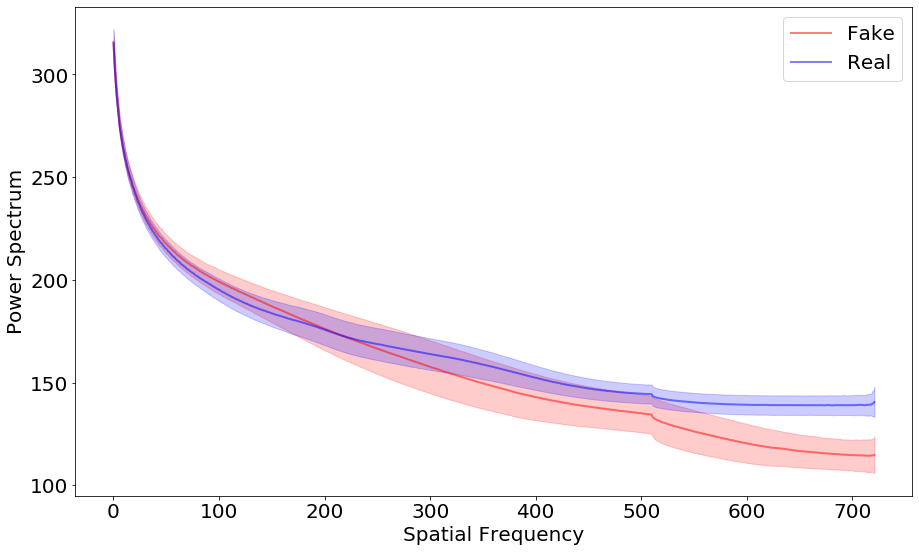

In [234]:
num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])
    
# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)
ax.legend()
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)

### Classification

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

num = 5
LR = 0
SVM = 0
SVM_r = 0
SVM_p = 0


for z in range(num):
    # read python dict back from the file
    pkl_file = open('dataset_freq_1000.pkl', 'rb')
    
    data = pickle.load(pkl_file)

    pkl_file.close()
    X = data["data"]
    y = data["label"]


    try:

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

        from sklearn.svm import SVC
        svclassifier = SVC(kernel='linear')
        svclassifier.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(svclassifier.score(X_test, y_test)))
               
        from sklearn.svm import SVC
        svclassifier_r = SVC(C=3.1, kernel='rbf', gamma=0.00002)
        svclassifier_r.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(svclassifier_r.score(X_test, y_test)))
                
        from sklearn.svm import SVC
        svclassifier_p = SVC(kernel='poly')
        svclassifier_p.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(svclassifier_p.score(X_test, y_test)))
        
        from sklearn.linear_model import LogisticRegression
        logreg = LogisticRegression(solver='liblinear', max_iter=1000)
        logreg.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

        
        SVM+=svclassifier.score(X_test, y_test)
        SVM_r+=svclassifier_r.score(X_test, y_test)
        SVM_p+=svclassifier_p.score(X_test, y_test)
        LR+=logreg.score(X_test, y_test)

 
    except:
        num-=1
        print(num)
    
print("Average SVM: "+str(SVM/num))
print("Average SVM_r: "+str(SVM_r/num))
print("Average SVM_p: "+str(SVM_p/num))
print("Average LR: "+str(LR/num))


/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarni

Average SVM: 1.0
Average SVM_r: 1.0
Average SVM_p: 1.0
Average LR: 1.0


/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [151]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# read python dict back from the file
pkl_file = open('dataset_freq_1000.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

from sklearn.cluster import KMeans
k = 2
kmeans = KMeans(n_clusters=k)
kmeans = kmeans.fit(X)
labels = kmeans.predict(X)

res =labels+y
cont=0
for z in range(len(res)):
    if res[z] == 1:
        cont+=1
print("Average KM: "+str(1-cont/len(res)))

Average KM: 0.8160000000000001
